# Imports

In [1]:
#import numpy as np
import torch
from torch import nn
#from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from torch.nn.attention.flex_attention import flex_attention, create_block_mask
#import transformers
import pandas as pd
import os
import timeit
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
load_dotenv()

True

Some of realization I take from here https://github.com/rasbt/LLMs-from-scratch/blob/main/ch03/02_bonus_efficient-multihead-attention/mha-implementations.ipynb

But I conduct investigation with CPU/GPU setup on Consumer CPU and Consumer GPU:
Ryzen 7700X and RTX 4060ti 16gb

# Config

In [2]:
torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 8
context_len = 1024
embed_dim = 768
dropout=0.1 
num_heads=4
qkv_bias=False

# Data

In [3]:
embeddings = torch.randn((batch_size, context_len, embed_dim), device=device)

# Different MHA

## Vanilla MHA

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0)

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.size()
        queries = self.W_query(x) # b, num_tokens, self.d_out
        keys = self.W_key(x) # b, num_tokens, self.d_out
        values = self.W_value(x) # b, num_tokens, self.d_out

        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        queries = queries.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim
        keys = keys.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim
        values = values.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim

        att_scores = queries @ keys.transpose(2, 3) # shapes = (num_tokens, self.head_dim) @ (self.head_dim, num_tokens) -> (num_tokens, num_tokens)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        att_scores.masked_fill_(mask_bool, -torch.inf)

        att_weights = torch.softmax(att_scores / keys.shape[-1]**0.5, dim=-1)
        att_weights = self.dropout(att_weights)

        context_vec = (att_weights @ values).transpose(1, 2) # (num_tokens, num_tokens) @ (num_tokens, self.head_dim) -> (num_tokens, self.head_dim) -> transpose(1,2) of (b, self.num_heads, num_tokens, self.head_dim) ->
        # -> (b, num_tokens, self.num_heads, self.head_dim) as view in previous code after inference of Linear layers
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec

In [ ]:
mha_vanilla = MultiHeadAttention(d_in=embed_dim, d_out=embed_dim, context_length=context_len, dropout=dropout, num_heads=num_heads, qkv_bias=qkv_bias)

GPU

In [132]:
mha_vanilla.to(device)

MultiHeadAttention(
  (W_key): Linear(in_features=768, out_features=768, bias=False)
  (W_query): Linear(in_features=768, out_features=768, bias=False)
  (W_value): Linear(in_features=768, out_features=768, bias=False)
  (out_proj): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [24]:
%%timeit
mha_vanilla(embeddings)

11.9 ms ± 603 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
mha_vanilla(embeddings)[0][0][:20]

tensor([ 0.2587, -0.1688, -0.3089, -0.6273, -0.4353,  0.6085, -0.0685,  0.3217,
        -0.1282, -0.3728, -0.3852,  0.6471,  0.0223, -0.4445, -0.0847,  0.0053,
         0.0742,  0.2241,  0.2241,  0.2308], device='cuda:0',
       grad_fn=<SliceBackward0>)

CPU

In [25]:
mha_vanilla.to('cpu')
embeddings_cpu = embeddings.to('cpu')

In [26]:
%%timeit
mha_vanilla(embeddings_cpu)

383 ms ± 8.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's check autocast

GPU

In [137]:
%%timeit
with torch.autocast(device_type=device.type, dtype=torch.bfloat16):
    mha_vanilla(embeddings)

616 μs ± 98.4 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Vanilla MHA with torch.functional softmax

In [5]:
class MultiHeadAttentionF(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0)

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.size()
        queries = self.W_query(x) # b, num_tokens, self.d_out
        keys = self.W_key(x) # b, num_tokens, self.d_out
        values = self.W_value(x) # b, num_tokens, self.d_out

        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        queries = queries.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim
        keys = keys.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim
        values = values.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim

        att_scores = queries @ keys.transpose(2, 3) # shapes = (num_tokens, self.head_dim) @ (self.head_dim, num_tokens) -> (num_tokens, num_tokens)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        att_scores.masked_fill_(mask_bool, -torch.inf)

        att_weights = F.softmax(att_scores / keys.shape[-1]**0.5, dim=-1)
        att_weights = self.dropout(att_weights)

        context_vec = (att_weights @ values).transpose(1, 2) # (num_tokens, num_tokens) @ (num_tokens, self.head_dim) -> (num_tokens, self.head_dim) -> transpose(1,2) of (b, self.num_heads, num_tokens, self.head_dim) ->
        # -> (b, num_tokens, self.num_heads, self.head_dim) as view in previous code after inference of Linear layers
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec

In [ ]:
mha_vanillaF = MultiHeadAttentionF(d_in=embed_dim, d_out=embed_dim, context_length=context_len, dropout=dropout, num_heads=num_heads, qkv_bias=qkv_bias)

GPU

In [48]:
mha_vanillaF.to(device)

MultiHeadAttentionF(
  (W_key): Linear(in_features=768, out_features=768, bias=False)
  (W_query): Linear(in_features=768, out_features=768, bias=False)
  (W_value): Linear(in_features=768, out_features=768, bias=False)
  (out_proj): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [49]:
%%timeit
mha_vanillaF(embeddings)

11.8 ms ± 582 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [50]:
mha_vanillaF(embeddings)[0][0][:20]

tensor([ 0.2789, -0.5492, -0.1859,  0.3443, -0.0859,  0.2804,  0.0042,  0.2920,
         0.0533,  0.2780, -0.1724, -0.0357,  0.4125,  0.1117, -0.0151,  0.2045,
        -0.2745, -0.6634, -0.4224,  0.0542], device='cuda:0',
       grad_fn=<SliceBackward0>)

CPU

In [52]:
mha_vanillaF.to('cpu')
embeddings_cpu = embeddings.to('cpu')

In [53]:
%%timeit
mha_vanillaF(embeddings_cpu)

397 ms ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's check autocast

GPU

In [ ]:
%%timeit
with torch.autocast(device_type=device.type, dtype=torch.bfloat16):
    mha_vanilla(embeddings)

616 μs ± 98.4 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Combined QKV MHA

In [6]:
class MultiHeadAttentionQKV(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0)

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.size()

        qkv = self.W_qkv(x) # b, num_tokens, 3 * self.d_out
        queries, keys, values = qkv.split(self.d_out, dim=2) # third dimension (3 * self.d_out) splitted onto 3 separate weight matrix

        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        queries = queries.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim
        keys = keys.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim
        values = values.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim

        att_scores = queries @ keys.transpose(2, 3) # shapes = (num_tokens, self.head_dim) @ (self.head_dim, num_tokens) -> (num_tokens, num_tokens)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        att_scores.masked_fill_(mask_bool, -torch.inf)

        att_weights = torch.softmax(att_scores / keys.shape[-1]**0.5, dim=-1)
        att_weights = self.dropout(att_weights)

        context_vec = (att_weights @ values).transpose(1, 2) # (num_tokens, num_tokens) @ (num_tokens, self.head_dim) -> (num_tokens, self.head_dim) -> transpose(1,2) of (b, self.num_heads, num_tokens, self.head_dim) ->
        # -> (b, num_tokens, self.num_heads, self.head_dim) as view in previous code after inference of Linear layers
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec

In [ ]:
mha_qkv = MultiHeadAttentionQKV(d_in=embed_dim, d_out=embed_dim, context_length=context_len, dropout=dropout, num_heads=num_heads, qkv_bias=qkv_bias)

GPU

In [56]:
mha_qkv.to(device)

MultiHeadAttentionQKV(
  (W_qkv): Linear(in_features=768, out_features=2304, bias=False)
  (out_proj): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [57]:
%%timeit
mha_qkv(embeddings)

11.9 ms ± 738 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [58]:
mha_qkv(embeddings)[0][0][:20]

tensor([-0.1313, -0.5466, -0.1908, -0.1089,  0.3935,  0.3790, -0.0702,  0.2113,
        -0.4252,  0.2259,  0.1563,  0.1851,  0.3420, -0.2861, -0.5285,  0.5380,
        -0.1931, -0.1920, -0.0404,  0.3192], device='cuda:0',
       grad_fn=<SliceBackward0>)

CPU

In [59]:
mha_qkv.to('cpu')
embeddings_cpu = embeddings.to('cpu')

In [60]:
%%timeit
mha_qkv(embeddings_cpu)

376 ms ± 7.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's check autocast

GPU

In [ ]:
%%timeit
with torch.autocast(device_type=device.type, dtype=torch.bfloat16):
    mha_vanilla(embeddings)

616 μs ± 98.4 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## MHA with Einsum

In [7]:
import math

class MHAEinsum(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        # Initialize parameters for Q, K, V
        self.W_query = nn.Parameter(torch.randn(d_out, d_in))
        self.W_key = nn.Parameter(torch.randn(d_out, d_in))
        self.W_value = nn.Parameter(torch.randn(d_out, d_in))

        if qkv_bias:
            self.bias_q = nn.Parameter(torch.zeros(d_out))
            self.bias_k = nn.Parameter(torch.zeros(d_out))
            self.bias_v = nn.Parameter(torch.zeros(d_out))
        else:
            self.register_parameter("bias_q", None)
            self.register_parameter("bias_k", None)
            self.register_parameter("bias_v", None)

        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

        # Initialize parameters
        self.reset_parameters()


    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.W_query, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.W_key, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.W_value, a=math.sqrt(5))
        if self.bias_q is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_query)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias_q, -bound, bound)
            nn.init.uniform_(self.bias_k, -bound, bound)
            nn.init.uniform_(self.bias_v, -bound, bound)

    def forward(self, x):
        b, n, _ = x.shape

        # Calculate Q, K, V using einsum, first perform linear transformations
        Q = torch.einsum("bnd,di->bni", x, self.W_query)
        K = torch.einsum("bnd,di->bni", x, self.W_key)
        V = torch.einsum("bnd,di->bni", x, self.W_value)

        # Add biases if they are used
        if self.bias_q is not None:
            Q += self.bias_q
            K += self.bias_k
            V += self.bias_v

        # Reshape for multi-head attention
        Q = Q.view(b, n, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(b, n, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(b, n, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.einsum("bhnd,bhmd->bhnm", Q, K) / (self.head_dim ** 0.5)

        # Apply mask
        mask = self.mask[:n, :n].unsqueeze(0).unsqueeze(1).expand(b, self.num_heads, n, n)
        scores = scores.masked_fill(mask.bool(), -torch.inf)

        # Softmax and dropout
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Aggregate the attended context vectors
        context_vec = torch.einsum("bhnm,bhmd->bhnd", attn_weights, V)

        # Combine heads and project the output
        context_vec = context_vec.transpose(1, 2).reshape(b, n, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec

In [ ]:
mha_ein = MHAEinsum(d_in=embed_dim, d_out=embed_dim, context_length=context_len, dropout=dropout, num_heads=num_heads, qkv_bias=qkv_bias)

GPU

In [63]:
mha_ein.to(device)

MHAEinsum(
  (out_proj): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [64]:
%%timeit
mha_ein(embeddings)

13.1 ms ± 123 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [65]:
mha_ein(embeddings)[0][0][:20]

tensor([-0.4242, -0.1845,  0.9829, -0.4848, -0.3471,  0.4352, -0.0564,  0.5896,
         0.2838, -0.6671,  0.3433, -0.7988, -0.0607,  0.3830,  0.0138, -0.3838,
        -0.0921, -0.4485, -0.1877,  0.1288], device='cuda:0',
       grad_fn=<SliceBackward0>)

CPU

In [66]:
mha_ein.to('cpu')
embeddings_cpu = embeddings.to('cpu')

In [67]:
%%timeit
mha_ein(embeddings_cpu)

394 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's check autocast

GPU

In [ ]:
%%timeit
with torch.autocast(device_type=device.type, dtype=torch.bfloat16):
    mha_vanilla(embeddings)

616 μs ± 98.4 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## MHA with Scaled-dot-product

In [8]:
class MultiHeadAttentionDP(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0)

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = dropout#nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.size()
        queries = self.W_query(x) # b, num_tokens, self.d_out
        keys = self.W_key(x) # b, num_tokens, self.d_out
        values = self.W_value(x) # b, num_tokens, self.d_out

        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        queries = queries.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim
        keys = keys.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim
        values = values.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim

        # All code below we replace with torch.nn.functional.scaled_dot_product_attention
        context_vec = torch.nn.functional.scaled_dot_product_attention(queries, keys, values, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)

        # att_scores = queries @ keys.transpose(2, 3) # shapes = (num_tokens, self.head_dim) @ (self.head_dim, num_tokens) -> (num_tokens, num_tokens)
        # mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        # att_scores.masked_fill_(mask_bool, -torch.inf)
        # att_weights = torch.softmax(att_scores / keys.shape[-1]**0.5, dim=-1)
        # att_weights = self.dropout(att_weights)
        # context_vec = (att_weights @ values).transpose(1, 2) # (num_tokens, num_tokens) @ (num_tokens, self.head_dim) -> (num_tokens, self.head_dim) -> transpose(1,2) of (b, self.num_heads, num_tokens, self.head_dim) ->
        # # -> (b, num_tokens, self.num_heads, self.head_dim) as view in previous code after inference of Linear layers
        
        # Reshape etc
        context_vec = context_vec.transpose(1, 2).contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec

In [ ]:
mha_dp = MultiHeadAttentionDP(d_in=embed_dim, d_out=embed_dim, context_length=context_len, dropout=dropout, num_heads=num_heads, qkv_bias=qkv_bias)

GPU

In [76]:
mha_dp.to(device)

MultiHeadAttentionDP(
  (W_key): Linear(in_features=768, out_features=768, bias=False)
  (W_query): Linear(in_features=768, out_features=768, bias=False)
  (W_value): Linear(in_features=768, out_features=768, bias=False)
  (out_proj): Linear(in_features=768, out_features=768, bias=True)
)

In [77]:
%%timeit
mha_dp(embeddings)

6.92 ms ± 29.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


x2 boost

In [78]:
mha_dp(embeddings)[0][0][:20]

tensor([-0.6507,  0.9647,  1.0425, -0.4682,  0.7048,  0.5620, -0.1579,  0.5434,
        -0.1678, -0.6890, -0.0766, -0.1730, -0.1573,  0.0446, -0.3361, -0.0669,
        -0.3259,  0.2017,  0.4310,  0.1543], device='cuda:0',
       grad_fn=<SliceBackward0>)

CPU

In [79]:
mha_dp.to('cpu')
embeddings_cpu = embeddings.to('cpu')

In [80]:
%%timeit
mha_dp(embeddings_cpu)

400 ms ± 22.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's check autocast

GPU

In [ ]:
%%timeit
with torch.autocast(device_type=device.type, dtype=torch.bfloat16):
    mha_vanilla(embeddings)

616 μs ± 98.4 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## MHA with Scaled-dot-product and combined QKV

In [9]:
class MultiHeadAttentionDP_QKV(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0)

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = dropout#nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.size()
        qkv = self.W_qkv(x) # b, num_tokens, 3 * self.d_out
        queries, keys, values = qkv.split(self.d_out, dim=2)

        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        queries = queries.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim
        keys = keys.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim
        values = values.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim

        # All code below we replace with torch.nn.functional.scaled_dot_product_attention
        context_vec = torch.nn.functional.scaled_dot_product_attention(queries, keys, values, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)

        # att_scores = queries @ keys.transpose(2, 3) # shapes = (num_tokens, self.head_dim) @ (self.head_dim, num_tokens) -> (num_tokens, num_tokens)
        # mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        # att_scores.masked_fill_(mask_bool, -torch.inf)
        # att_weights = torch.softmax(att_scores / keys.shape[-1]**0.5, dim=-1)
        # att_weights = self.dropout(att_weights)
        # context_vec = (att_weights @ values).transpose(1, 2) # (num_tokens, num_tokens) @ (num_tokens, self.head_dim) -> (num_tokens, self.head_dim) -> transpose(1,2) of (b, self.num_heads, num_tokens, self.head_dim) ->
        # # -> (b, num_tokens, self.num_heads, self.head_dim) as view in previous code after inference of Linear layers
        
        # Reshape etc
        context_vec = context_vec.transpose(1, 2).contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec

In [ ]:
mha_dp_qkv = MultiHeadAttentionDP_QKV(d_in=embed_dim, d_out=embed_dim, context_length=context_len, dropout=dropout, num_heads=num_heads, qkv_bias=qkv_bias)

GPU

In [89]:
mha_dp_qkv.to(device)

MultiHeadAttentionDP_QKV(
  (W_qkv): Linear(in_features=768, out_features=2304, bias=False)
  (out_proj): Linear(in_features=768, out_features=768, bias=True)
)

In [90]:
%%timeit
mha_dp_qkv(embeddings)

6.84 ms ± 27.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [91]:
mha_dp_qkv(embeddings)[0][0][:20]

tensor([ 0.4122,  0.3751,  0.1308, -0.3931,  0.4668, -0.0658,  0.2349, -0.3577,
         0.2417, -0.4068, -0.0244,  0.2409, -0.1503,  0.2751,  0.0163,  0.2376,
        -0.3103,  0.1475, -0.2411, -0.5817], device='cuda:0',
       grad_fn=<SliceBackward0>)

CPU

In [92]:
mha_dp_qkv.to('cpu')
embeddings_cpu = embeddings.to('cpu')

In [93]:
%%timeit
mha_dp_qkv(embeddings_cpu)

411 ms ± 16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's check autocast

GPU

In [ ]:
%%timeit
with torch.autocast(device_type=device.type, dtype=torch.bfloat16):
    mha_vanilla(embeddings)

616 μs ± 98.4 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## MHA Pytorch built-in

In [10]:
class MHAPyTorch(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False, need_weights=True):
        super().__init__()

        self.context_length = context_length
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=d_out,
            num_heads=num_heads,
            dropout=dropout,
            bias=qkv_bias,
            add_bias_kv=qkv_bias,
            batch_first=True,
        )

        self.need_weights = need_weights
        self.out_proj = nn.Linear(d_out, d_out)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

    def forward(self, x):
        b, num_tokens, d_in = x.size()

        # Ensure attn_mask is compatible with expected shape and `batch_first=True`
        # No need to manually adjust for num_heads; ensure it's right for the sequence
        if self.context_length >= num_tokens:
            attn_mask = self.mask[:num_tokens, :num_tokens]
        else:
            attn_mask = self.mask[:self.context_length, :self.context_length]

        # attn_mask broadcasting will handle batch_size dimension implicitly
        attn_output, _ = self.multihead_attn(
            x, x, x, attn_mask=attn_mask, need_weights=self.need_weights
        )

        context_vec = self.out_proj(attn_output)

        return context_vec

In [ ]:
mha_torch = MHAPyTorch(d_in=embed_dim, d_out=embed_dim, context_length=context_len, dropout=dropout, num_heads=num_heads, qkv_bias=qkv_bias)

GPU

In [97]:
mha_torch.to(device)

MHAPyTorch(
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=False)
  )
  (out_proj): Linear(in_features=768, out_features=768, bias=True)
)

In [98]:
%%timeit
mha_torch(embeddings)

487 μs ± 121 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Significant boost here

In [99]:
mha_torch(embeddings)[0][0][:20]

tensor([ 0.1265,  0.2446,  0.0797, -0.0448,  0.1704, -0.2221, -0.0832, -0.3347,
        -0.3488,  0.3705,  0.0370, -0.1837,  0.3036, -0.2020, -0.2883, -0.0963,
        -0.1082,  0.1825,  0.2147,  0.0461], device='cuda:0',
       grad_fn=<SliceBackward0>)

CPU

In [100]:
mha_torch.to('cpu')
embeddings_cpu = embeddings.to('cpu')

In [101]:
%%timeit
mha_torch(embeddings_cpu)

413 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's check autocast

GPU

In [ ]:
%%timeit
with torch.autocast(device_type=device.type, dtype=torch.bfloat16):
    mha_vanilla(embeddings)

616 μs ± 98.4 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Using PyTorch's torch.nn.MultiheadAttention with `scaled_dot_product_attention`

In [ ]:
mha_torch_dp = MHAPyTorch(d_in=embed_dim, d_out=embed_dim, context_length=context_len, dropout=dropout, num_heads=num_heads, qkv_bias=qkv_bias, need_weights=False)

GPU

In [104]:
mha_torch_dp.to(device)

MHAPyTorch(
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=False)
  )
  (out_proj): Linear(in_features=768, out_features=768, bias=True)
)

In [105]:
%%timeit
mha_torch_dp(embeddings)

12 ms ± 152 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Significant boost here

In [106]:
mha_torch_dp(embeddings)[0][0][:20]

tensor([ 0.2552,  0.1269, -0.1312,  0.0389,  0.0434,  0.3826, -0.2642,  0.2161,
        -0.2794, -0.2151,  0.3436, -0.3315, -0.1128, -0.0779, -0.1682, -0.2084,
        -0.1017, -0.3217, -0.0512,  0.1602], device='cuda:0',
       grad_fn=<SliceBackward0>)

CPU

In [107]:
mha_torch_dp.to('cpu')
embeddings_cpu = embeddings.to('cpu')

In [108]:
%%timeit
mha_torch_dp(embeddings_cpu)

427 ms ± 15.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's check autocast

GPU

In [ ]:
%%timeit
with torch.autocast(device_type=device.type, dtype=torch.bfloat16):
    mha_vanilla(embeddings)

616 μs ± 98.4 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## FlexAttention in Pytorch

In [127]:
def causal(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx


class MHAPyTorchFlexAttention(nn.Module):

    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads
        self.d_out = d_out

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = dropout
        # self.register_buffer("block_mask", create_block_mask(causal, B=None, H=None, Q_LEN=context_length, KV_LEN=context_length))
        # `create_block_mask` function does not support buffers, yet
        self.block_mask = create_block_mask(causal, B=None, H=None, Q_LEN=context_length, KV_LEN=context_length, device=device)


    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_heads, num_tokens, head_dim)
        queries, keys, values = qkv

        # use_dropout = 0. if not self.training else self.dropout

        # Ensure attn_mask is compatible with expected shape and `batch_first=True`
        # No need to manually adjust for num_heads; ensure it's right for the sequence
        if self.context_length >= num_tokens:
            attn_mask = self.block_mask[:num_tokens, :num_tokens]
        else:
            attn_mask = self.block_mask[:self.context_length, :self.context_length]

        context_vec = flex_attention(queries, keys, values, block_mask=attn_mask)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch_size, num_tokens, self.d_out)

        context_vec = self.proj(context_vec)

        return context_vec

In [ ]:
mha_torch_flex = MHAPyTorchFlexAttention(d_in=embed_dim, d_out=embed_dim, context_length=context_len, dropout=dropout, num_heads=num_heads, qkv_bias=qkv_bias)

GPU

In [125]:
mha_torch_flex.to(device)

MHAPyTorchFlexAttention(
  (qkv): Linear(in_features=768, out_features=2304, bias=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
)

In [128]:
%%timeit
mha_torch_flex(embeddings)

16.4 ms ± 36.4 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Significant boost here

In [117]:
mha_torch_flex(embeddings)[0][0][:20]

tensor([-0.0443, -0.0227,  0.0127, -0.0257, -0.0044, -0.0001, -0.0042, -0.0336,
         0.0128, -0.0318, -0.0133,  0.0093,  0.0134, -0.0457,  0.0139,  0.0129,
         0.0038,  0.0124, -0.0079, -0.0258], device='cuda:0',
       grad_fn=<SliceBackward0>)

CPU

In [122]:
mha_torch_flex.to('cpu')
embeddings_cpu = embeddings.to('cpu')

In [123]:
%%timeit
mha_torch_flex(embeddings_cpu)

RuntimeError: Expect q/k/v and block_mask to be on the same device but got cpu and cuda:0.

Don't work on CPU?

Let's check autocast

GPU

In [ ]:
%%timeit
with torch.autocast(device_type=device.type, dtype=torch.bfloat16):
    mha_vanilla(embeddings)

616 μs ± 98.4 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## KV-cache

### 1 version

In [ ]:
class KVCache:
    """
    Класс для управления кэшированием ключей (K) и значений (V) в трансформерах.
    Полезно для поэтапной генерации (inference), чтобы не перемножать контексты заново.
    """
    def __init__(self):
        # Словарь для хранения пар (ключи, значения) на каждый слой
        self.cache = {}

    def set(self, layer_id, key, value):
        """
        Установить или обновить кэш для заданного слоя.
        Если ранее были сохранены ключи/значения, они дополняются.
        """
        if layer_id in self.cache:
            # Конкатенируем по размерности временной последовательности
            k_prev, v_prev = self.cache[layer_id]
            key = torch.cat([k_prev, key], dim=2)  # dim=2 => seq_len
            value = torch.cat([v_prev, value], dim=2)
        self.cache[layer_id] = (key, value)

    def get(self, layer_id):
        """
        Получить кэшированные ключи/значения для заданного слоя.
        Если нет кэша, возвращает (None, None).
        """
        return self.cache.get(layer_id, (None, None))

    def clear(self):
        """
        Очистить весь кэш.
        """
        self.cache.clear()

### 2 version

In [43]:
class KVCache:
    """
    It's first version of my implementation of KV-cache.
    Maybe something wrong, need refactor
    """
    def __init__(self, batch_size, d_out, context_length, num_heads, device): #batch_size, num_heads, max_seq_len, head_dim, device):

        self.batch_size = batch_size
        self.num_heads = num_heads
        self.head_dim = d_out // self.num_heads
        self.context_length = context_length
        self.device = device

        # Предварительно выделяем память для ключей и значений
        self.keys = torch.empty(batch_size, num_heads, self.context_length, self.head_dim, device=self.device)
        self.values = torch.empty(batch_size, num_heads, self.context_length, self.head_dim, device=self.device)
        # Индекс, указывающий на текущую длину кэша
        self.current_len = 0
        
    def update(self, new_keys, new_values):
        """
        new_keys: тензор с формой [batch_size, num_heads, context_length, self.head_dim] 
        Т.е. после keys = keys.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim
        new_values: аналогично
        Записывает новые ключи и значения в кэш.
        """
        new_seq_len = new_keys.size(2)
        end_pos = self.current_len + new_seq_len
        
        #if end_pos > self.context_length:
        #    raise ValueError("Превышена максимальная длина кэша. Рассмотрите возможность использования скользящего окна или увеличения max_seq_len.")
        
        # Записываем новые данные в заранее выделенные тензоры
        self.keys[:, :, self.current_len:end_pos, :] = new_keys
        self.values[:, :, self.current_len:end_pos, :] = new_values
        
        # Обновляем указатель текущей длины
        self.current_len = end_pos

    def get_cache(self):
        """
        Возвращает актуальные ключи и значения до текущей длины.
        """
        #return self.keys[:, :, :self.current_len, :], self.values[:, :, :self.current_len, :]
        #return self.keys, self.values
        return self.keys[:, :, -self.context_length:, :], self.values[:, :, -self.context_length:, :]

    def reset(self):
        """
        Сбрасывает кэш для начала новой последовательности.
        """
        self.current_len = 0

In [56]:
class MultiHeadAttentionWithPreallocatedKV(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0)

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x, kv_cache=None):
        b, num_tokens, d_in = x.size()
        queries = self.W_query(x) # b, num_tokens, self.d_out
        keys = self.W_key(x) # b, num_tokens, self.d_out
        values = self.W_value(x) # b, num_tokens, self.d_out

        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        queries = queries.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim
        keys = keys.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim
        values = values.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim

        # KV-cache update
        if (kv_cache != None):
            kv_cache.update(new_keys=keys, new_values=values)
            k_full, v_full = kv_cache.get_cache()
        else:
            k_full, v_full = keys, values
            
        att_scores = queries @ k_full.transpose(2, 3) # shapes = (num_tokens, self.head_dim) @ (self.head_dim, num_tokens) -> (num_tokens, num_tokens)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        att_scores.masked_fill_(mask_bool, -torch.inf)

        att_weights = torch.softmax(att_scores / k_full.shape[-1]**0.5, dim=-1)
        att_weights = self.dropout(att_weights)

        context_vec = (att_weights @ v_full).transpose(1, 2) # (num_tokens, num_tokens) @ (num_tokens, self.head_dim) -> (num_tokens, self.head_dim) -> transpose(1,2) of (b, self.num_heads, num_tokens, self.head_dim) ->
        # -> (b, num_tokens, self.num_heads, self.head_dim) as view in previous code after inference of Linear layers
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec

In [60]:
kv_cache = KVCache(batch_size=batch_size, d_out=embed_dim, context_length=context_len*2, num_heads=num_heads, device=device)
mha_torch_kv_cache = MultiHeadAttentionWithPreallocatedKV(d_in=embed_dim, d_out=embed_dim, context_length=context_len, dropout=dropout, num_heads=num_heads, qkv_bias=qkv_bias)

In [61]:
mha_torch_kv_cache.to(device)

MultiHeadAttentionWithPreallocatedKV(
  (W_key): Linear(in_features=768, out_features=768, bias=False)
  (W_query): Linear(in_features=768, out_features=768, bias=False)
  (W_value): Linear(in_features=768, out_features=768, bias=False)
  (out_proj): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [47]:
mha_torch_kv_cache(embeddings).shape

torch.Size([8, 1024, 768])

In [48]:
kv_cache.get_cache()[-1].shape

torch.Size([8, 4, 2048, 192])

In [49]:
kv_cache.get_cache()[-1]

tensor([[[[ 2.3511e-38,  2.3694e-38,  2.3694e-38,  ...,  2.3694e-38,
            2.3694e-38,  2.3694e-38],
          [ 9.2196e-41,  2.3694e-38,  2.3694e-38,  ...,  2.3694e-38,
            9.2196e-41,  2.3511e-38],
          [ 2.3694e-38,  2.3511e-38,  2.3694e-38,  ...,  2.3694e-38,
            2.3511e-38,  9.2196e-41],
          ...,
          [ 2.3511e-38,  2.3694e-38,  2.3694e-38,  ...,  2.3694e-38,
            2.3694e-38,  2.3694e-38],
          [ 2.3694e-38,  2.3694e-38,  2.3694e-38,  ...,  9.2196e-41,
            2.3694e-38,  2.3694e-38],
          [ 2.3694e-38,  2.3694e-38,  9.2196e-41,  ...,  2.3694e-38,
            2.3694e-38,  2.3694e-38]],

         [[ 2.3694e-38,  2.3694e-38,  2.3694e-38,  ...,  2.3694e-38,
            2.3694e-38,  2.3694e-38],
          [ 2.3694e-38,  2.3694e-38,  2.3694e-38,  ...,  2.3511e-38,
            2.3694e-38,  2.3510e-38],
          [ 2.3694e-38,  2.3510e-38,  9.2196e-41,  ...,  2.3694e-38,
            2.3694e-38,  2.3694e-38],
          ...,
     

In [50]:
mha_torch_kv_cache(embeddings).shape

torch.Size([8, 1024, 768])

In [51]:
kv_cache.get_cache()[-1]

tensor([[[[ 2.3511e-38,  2.3694e-38,  2.3694e-38,  ...,  2.3694e-38,
            2.3694e-38,  2.3694e-38],
          [ 9.2196e-41,  2.3694e-38,  2.3694e-38,  ...,  2.3694e-38,
            9.2196e-41,  2.3511e-38],
          [ 2.3694e-38,  2.3511e-38,  2.3694e-38,  ...,  2.3694e-38,
            2.3511e-38,  9.2196e-41],
          ...,
          [ 2.3511e-38,  2.3694e-38,  2.3694e-38,  ...,  2.3694e-38,
            2.3694e-38,  2.3694e-38],
          [ 2.3694e-38,  2.3694e-38,  2.3694e-38,  ...,  9.2196e-41,
            2.3694e-38,  2.3694e-38],
          [ 2.3694e-38,  2.3694e-38,  9.2196e-41,  ...,  2.3694e-38,
            2.3694e-38,  2.3694e-38]],

         [[ 2.3694e-38,  2.3694e-38,  2.3694e-38,  ...,  2.3694e-38,
            2.3694e-38,  2.3694e-38],
          [ 2.3694e-38,  2.3694e-38,  2.3694e-38,  ...,  2.3511e-38,
            2.3694e-38,  2.3510e-38],
          [ 2.3694e-38,  2.3510e-38,  9.2196e-41,  ...,  2.3694e-38,
            2.3694e-38,  2.3694e-38],
          ...,
     

In [52]:
kv_cache.get_cache()[-1].shape

torch.Size([8, 4, 2048, 192])

In [25]:
%%timeit
mha_torch_kv_cache(embeddings)

11 ms ± 101 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
#kv_cache 
#mha_torch_kv_cache (d_in=embed_dim, d_out=embed_dim, context_length=context_len, dropout=dropout, num_heads=num_heads, qkv_bias=qkv_bias)

# Одношаговое применение (без кэша)
x = torch.rand(batch_size, context_len, embed_dim).to(device)
out = mha_torch_kv_cache(x)
print("Выход без кэша:", out.shape)

# Поэтапная генерация (decode)
kv_cache.reset()
outputs = []
for t in range(context_len):
    xt = x[:, t:t+1, :] # It is important, because we take only one token at step and inference k,v,q with one vector
    out_t = mha_torch_kv_cache(xt, kv_cache=kv_cache)
    outputs.append(out_t)
result = torch.cat(outputs, dim=1)
print("Выход с поэтапной генерацией:", result.shape)

Выход без кэша: torch.Size([8, 1024, 768])
Выход с поэтапной генерацией: torch.Size([8, 1024, 768])


In [64]:
%%timeit
out = mha_torch_kv_cache(x)

11.3 ms ± 624 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [66]:
%%timeit
kv_cache.reset()
outputs = []
for t in range(context_len):
    xt = x[:, t:t+1, :]
    out_t = mha_torch_kv_cache(xt, kv_cache=kv_cache)
    outputs.append(out_t)
result = torch.cat(outputs, dim=1)

494 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## MLA (Multi-Head Latent Attention)

### Reworked code

With Cache

In [9]:
class MultiHeadLatentAttentionCached(nn.Module):
    """
    Размер латентного вектора d_c задаётся при инициализации (d_c << num_heads * head_dim).
    d_latent: размер латентного вектора (d_latent << num_heads * head_dim) или (d_latent << d_in)
    """

    def __init__(self, d_in, d_latent, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_in % num_heads == 0), "d_in должно делиться на num_heads"

        self.d_in = d_in
        self.d_latent = d_latent
        self.num_heads = num_heads
        self.head_dim = d_in // num_heads

        # 1) Матрица перевода в латентное пространство  
        self.W_latent = nn.Linear(self.d_in, self.d_latent, bias=qkv_bias)
        
        # 2) Матрицы восстановления ключей и значений из латентного пространства (K and V only)
        self.W_key_from_latent = nn.Linear(self.d_latent, self.d_in, bias=qkv_bias) # shape of d_in is (head_dim * num_heads), then we split d_in onto heads
        self.W_value_from_latent = nn.Linear(self.d_latent, self.d_in, bias=qkv_bias) # shape of d_in is (head_dim * num_heads), then we split d_in onto heads
        
        # 3) Query считаем, как обычно из исходного пространства, а не из латентного
        self.W_query = nn.Linear(self.d_in, self.d_in, bias=qkv_bias)
        
        # 4) Выходная проекция, как обычно
        self.out_proj = nn.Linear(self.d_in, self.d_in, bias=qkv_bias)

        # Нормировочный коэффициент 1/√d_k
        self.scale = 1.0 / (self.head_dim ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x, cache_latent=None):
        b, num_tokens, d_in = x.size()

        latent_all = self.W_latent(x)  # b, num_tokens, self.d_in

        # 2) Обновляем кэш только для латентного состояния
        if (cache_latent is not None):
            # Допускаем, что cache_latent.shape = (batch_size, t-1, d_latent),
            # где t-1 < seq_len (т.е. мы модифицируем для новых токенов).
            # В данном упрощённом примере считаем, что всё seq_len идёт сразу, и cache_c=None при обучении.
            #latent = torch.cat([cache_latent, latent_all], dim=1)  # (batch_size, t, d_latent)
            cache_latent.update(new_latent=latent_all)
            latent = cache_latent.get_cache()
        else:
            latent = latent_all  # (batch_size, num_tokens, d_latent)

        # 3) Запросы маппятся из исходной размерности, не латентной
        queries = self.W_query(x) # b, num_tokens, self.d_in
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim

        # 4) K и V из латентного пространства (Восстанавливаем K и V «на лету» из кэша C) ^_^:
        keys = self.W_key_from_latent(latent) # (batch_size, num_tokens, d_latent) -> (b, num_tokens, d_in)
        values = self.W_value_from_latent(latent) # (batch_size, num_tokens, d_latent) -> (b, num_tokens, d_in)

        # Как БЫЛО в ванильном трансформере
        # keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        # values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        # Как теперь СТАЛО в MLE трансформере
        keys = keys.view(b, -1, self.num_heads, self.head_dim)
        values = values.view(b, -1, self.num_heads, self.head_dim)

        # Здесь без изменений
        keys = keys.transpose(1, 2) # b, self.num_heads, num_tokens (-1), self.head_dim # только один токен??
        values = values.transpose(1, 2) # b, self.num_heads, num_tokens (-1), self.head_dim # только один токен??

        att_scores = queries @ keys.transpose(2, 3) # shapes = (num_tokens, self.head_dim) @ (self.head_dim, num_tokens) -> (num_tokens, num_tokens)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens] # Убрать?
        att_scores.masked_fill_(mask_bool, -torch.inf)

        att_weights = torch.softmax(att_scores * self.scale, dim=-1) #/ keys.shape[-1]**0.5, dim=-1)
        att_weights = self.dropout(att_weights)

        context_vec = (att_weights @ values).transpose(1, 2) # (num_tokens, num_tokens) @ (num_tokens, self.head_dim) -> (num_tokens, self.head_dim) -> transpose(1,2) of (b, self.num_heads, num_tokens, self.head_dim) ->
        # -> (b, num_tokens, self.num_heads, self.head_dim) as view in previous code after inference of Linear layers
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_in)
        context_vec = self.out_proj(context_vec)
        return context_vec

In [11]:
# batch_size = 2
# seq_len = 5      # длина текущего батча (например, при обучении = полная последовательность)
# d_model = 512
# h = 8            # 8 голов
# d_c = 128        # размер латентного вектора (<< h*d_k = 8*64=512)

# Инициализируем слой MLA
mla = MultiHeadLatentAttentionCached(d_in=embed_dim, d_latent=embed_dim//4, context_length=context_len, dropout=dropout, num_heads=num_heads, qkv_bias=qkv_bias)
mla.to(device)

# На обучении мы обычно cache_c=None, чтобы считать C для всех позиций сразу
output  = mla(embeddings, cache_latent=None)

In [13]:
embeddings.shape, output.shape

(torch.Size([8, 1024, 768]), torch.Size([8, 1024, 768]))

In [15]:
mla = MultiHeadLatentAttentionCached(d_in=embed_dim, d_latent=embed_dim//4, context_length=context_len, dropout=dropout, num_heads=num_heads, qkv_bias=qkv_bias)

GPU

In [16]:
mla.to(device)

MultiHeadLatentAttentionCached(
  (W_latent): Linear(in_features=768, out_features=192, bias=False)
  (W_key_from_latent): Linear(in_features=192, out_features=768, bias=False)
  (W_value_from_latent): Linear(in_features=192, out_features=768, bias=False)
  (W_query): Linear(in_features=768, out_features=768, bias=False)
  (out_proj): Linear(in_features=768, out_features=768, bias=False)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [17]:
%%timeit
mla(embeddings)

10.3 ms ± 506 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
mla(embeddings)[0][0][:20]

tensor([ 0.2964, -0.0022, -0.0053,  0.1108, -0.1387,  0.1931,  0.1918, -0.1082,
         0.1696, -0.1004,  0.2641,  0.1982,  0.2413,  0.1979, -0.0893, -0.1521,
         0.0416, -0.0358,  0.2436, -0.3870], device='cuda:0',
       grad_fn=<SliceBackward0>)

CPU

In [19]:
mla.to('cpu')
embeddings_cpu = embeddings.to('cpu')

In [20]:
%%timeit
mla(embeddings_cpu)

355 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's check autocast

GPU

In [ ]:
%%timeit
with torch.autocast(device_type=device.type, dtype=torch.bfloat16):
    mha_vanilla(embeddings)

616 μs ± 98.4 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Older version of code

In [ ]:
class MultiHeadLatentAttention(nn.Module):
    """
    Простой слой Multi-Head Latent Attention (MLA) без RoPE.
    Предполагаем, что модельная размерность d_model, число голов h, размерность каждой головы d_k.
    Размер латентного вектора d_c задаётся при инициализации (d_c << h*d_k).
    """

    def __init__(self, d_model: int, h: int, d_c: int):
        """
        Аргументы:
            d_model: размерность входного скрытого состояния (и выходного).
            h:      число голов.
            d_c:    размер латентного вектора (d_c << h * d_k).
        """
        super().__init__()
        assert d_model % h == 0, "d_model должно делиться на h"
        self.d_model = d_model
        self.h = h
        self.d_k = d_model // h  # размерность одной головы
        self.d_c = d_c

        # 1) Матрица латентной проекции: X → C
        #    Проецирует d_model → d_c
        self.W_c = nn.Linear(d_model, d_c, bias=False)

        # 2) Матрицы восстановления ключей и значений
        #    Для удобства мы объединим сразу все головы в один тензор размерности (d_c → h*d_k).
        self.W_kc = nn.Linear(d_c, h * self.d_k, bias=False)  # C → (h × d_k) для Key
        self.W_vc = nn.Linear(d_c, h * self.d_k, bias=False)  # C → (h × d_k) для Value

        # 3) Матрица для получения Q из X (как обычно, без латентного шага).
        #    Берём X (d_model) → Q_all (h*d_k).
        self.W_q = nn.Linear(d_model, h * self.d_k, bias=False)

        # 4) Выходная проекция после конкатенации всех голов (h*d_k → d_model)
        self.W_o = nn.Linear(h * self.d_k, d_model, bias=False)

        # Нормировочный коэффициент 1/√d_k
        self.scale = 1.0 / (self.d_k ** 0.5)

    def forward(self, X: torch.Tensor, cache_c: torch.Tensor = None):
        """
        Аргументы:
            X       : тензор размерности (batch_size, seq_len, d_model) — входные скрытые состояния.
            cache_c : накопленные латентные векторы из предыдущих шагов, размер (batch_size, t-1, d_c)
                      Если cache_c=None, предполагаем, что строим внимание внутри текущего батча “с нуля” (для обучения).
        Возвращает:
            output     : (batch_size, seq_len, d_model) — результат MLA.
            new_cache_c: (batch_size, t, d_c) — обновлённый кэш латентных векторов (если был передан).
        """

        batch_size, seq_len, _ = X.shape

        # 1) Вычисляем все латентные векторы C из X:
        #    C_all: (batch_size, seq_len, d_c)
        C_all = self.W_c(X)  # латентное представление каждой позиции

        # 2) Обновляем кэш (если есть):
        if cache_c is not None:
            # Допускаем, что cache_c.shape = (batch_size, t-1, d_c),
            # где t-1 < seq_len (т.е. мы модифицируем для новых токенов).
            # В данном упрощённом примере считаем, что всё seq_len идёт сразу, и cache_c=None при обучении.
            C = torch.cat([cache_c, C_all], dim=1)  # (batch_size, t, d_c)
        else:
            C = C_all  # (batch_size, seq_len, d_c)

        # Обновлённый кэш возвращаем пользователю:
        new_cache_c = C

        # 3) Вычисляем Q из X (все головы сразу):
        #    Q_all: (batch_size, seq_len, h*d_k)
        Q_all = self.W_q(X)

        # Перестроим Q_all в Q [batch_size, h, seq_len, d_k]
        Q = Q_all.view(batch_size, seq_len, self.h, self.d_k).transpose(1, 2)
        # теперь Q.shape = (batch_size, h, seq_len, d_k)

        # 4) Восстанавливаем K и V «на лету» из кэша C:
        #    Считаем full_K_all = C W_kc  и full_V_all = C W_vc:
        #    full_K_all: (batch_size, t, h*d_k), где t = текущая длина кеша
        full_K_all = self.W_kc(C)  # (batch_size, t, h*d_k)
        full_V_all = self.W_vc(C)  # (batch_size, t, h*d_k)

        # Перестраиваем в [batch_size, h, t, d_k]
        #    K.shape = (batch_size, h, t, d_k)
        #    V.shape = (batch_size, h, t, d_k)
        K = full_K_all.view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        V = full_V_all.view(batch_size, -1, self.h, self.d_k).transpose(1, 2)

        # 5) Рассчитываем Scaled Dot-Product Attention «по-головно»:
        #    Пример: batch_size=2, h=4, текущая длина кеша t=10, seq_len=5
        #    тогда Q: (2, 4, 5, d_k), K: (2, 4, 10, d_k), V: (2, 4, 10, d_k).
        #
        #    Считаем scores = Q @ K^T: (2, 4, 5, 10)
        #    Затем Softmax по последней размерности (t), и применяем к V.

        # Расчёт скоров: (batch_size, h, seq_len, t)
        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attn_weights = F.softmax(scores, dim=-1)  # (batch_size, h, seq_len, t)

        # Вычисляем значения (batch_size, h, seq_len, d_k)
        attn_output = torch.matmul(attn_weights, V)

        # 6) Снова конкатенируем головы: (batch_size, seq_len, h*d_k)
        attn_output = attn_output.transpose(1, 2).contiguous()
        # теперь форма (batch_size, seq_len, h, d_k) → (batch_size, seq_len, h*d_k)
        attn_output = attn_output.view(batch_size, seq_len, self.h * self.d_k)

        # 7) Финальный линейный слой W_o: (batch_size, seq_len, d_model)
        output = self.W_o(attn_output)

        # Возвращаем результат слоя MLA и новый кеш (латентные векторы)
        return output, new_cache_c


# -----------------------------
# Пример использования:
# -----------------------------
if __name__ == "__main__":
    batch_size = 2
    seq_len = 5      # длина текущего батча (например, при обучении = полная последовательность)
    d_model = 512
    h = 8            # 8 голов
    d_c = 128        # размер латентного вектора (<< h*d_k = 8*64=512)

    # Инициализируем слой MLA
    mla = MultiHeadLatentAttention(d_model=d_model, h=h, d_c=d_c)

    # Пример входного тензора: (batch_size, seq_len, d_model)
    X = torch.randn(batch_size, seq_len, d_model)

    # На обучении мы обычно cache_c=None, чтобы считать C для всех позиций сразу
    output, new_cache_c = mla(X, cache_c=None)

    print("Output shape:", output.shape)      # (2, 5, 512)
    print("New cache C shape:", new_cache_c.shape)  # (2, 5, 128)


## MLA (splitted Weight matrix)

### Reworked code

In [ ]:
class MHLACachedSplittedMatrix(nn.Module):
    """
    Размер латентного вектора d_c задаётся при инициализации (d_c << num_heads * head_dim).
    d_latent: размер латентного вектора (d_latent << num_heads * head_dim) или (d_latent << d_in)
    """

    def __init__(self, d_in, d_latent, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_in % num_heads == 0), "d_in должно делиться на num_heads"

        self.d_in = d_in
        self.d_latent = d_latent
        self.num_heads = num_heads
        self.head_dim_latent = d_latent // num_heads
        self.head_dim_out = d_in // num_heads

        # 1) Матрица перевода запросов в латентное пространство
        self.W_Q_latent = nn.Linear(self.d_in, self.d_latent, bias=qkv_bias)
        # Матрица перевода ключей в латентное пространство
        self.W_K_latent = nn.Linear(self.d_in, self.d_latent, bias=qkv_bias)
        
        # 2) Матрицы для прямого и обратного перевода значений для латентного пространства
        # Проекции значений: латентная и обратная
        self.W_V_to_latent = nn.Linear(self.d_in, self.d_latent, bias=qkv_bias)
        self.W_V_from_latent = nn.Linear(self.d_latent, self.d_in, bias=qkv_bias)

        # 4) Выходная проекция, как обычно
        self.out_proj = nn.Linear(self.d_in, self.d_in, bias=qkv_bias)

        # Нормировочный коэффициент 1/√d_k
        self.scale = 1.0 / (self.head_dim_latent ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

        # Предварительное слияние W_VL и W_VU (Do-Precompute)
        # W_VL.weight: (d_latent, d_in), W_VU.weight: (d_in, d_latent)
        # self.W_pre: (d_in, d_in)
        W_VL_w = self.W_VL.weight.data  # (d_latent, d_in)
        W_VU_w = self.W_VU.weight.data  # (d_in, d_latent)
        W_pre = W_VU_w @ W_VL_w         # объединённая матрица
        # Регистрируем как буфер, т.к. не обновляется при обучении
        self.register_buffer('W_pre', W_pre)

    def forward(self, x, cache_latent=None):
        """
        x: тензор формы (batch_size, seq_len, d_in)
        возвращает: (batch_size, seq_len, d_in)
        """
        b, num_tokens, d_in = x.size()

        # 1) Проецируем Q и латентные K
        queries_latent = self.W_Q_latent(x)            # (b, num_tokens, d_latent)
        keys_latent = self.W_K_latent(x)       # (b, num_tokens, d_latent)

        # 3) Запросы маппятся
        queries_latent = queries_latent.view(b, num_tokens, self.num_heads, self.head_dim_latent)
        queries_latent = queries_latent.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim_latent
        keys_latent = keys_latent.view(b, num_tokens, self.num_heads, self.head_dim_latent)
        keys_latent = keys_latent.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim_latent

        # 3) Вычисляем скоры внимания
        # (B, num_heads, T, T)
        att_scores = (queries_latent @ keys_latent.transpose(-1, -2)) * self.scale

        att_weights = F.softmax(att_scores, dim=-1)
        att_weights = self.dropout(att_weights)

        # 4) Декомпрессия V через предвычисленную матрицу
        # x @ W_pre: (B, T, d_in)
        V_decompress = x @ self.W_pre
        # Разбиваем по головам: (B, T, num_heads, head_dim_out)
        values = V_decompress.view(b, num_tokens, self.num_heads, self.head_dim_out)
        values = values.transpose(1, 2)  # (B, num_heads, T, head_dim_out)

        # 5) Вычисляем контекст
        # (B, num_heads, T, head_dim_out)
        context_vec = att_weights @ values
        # Перестраиваем в (B, T, d_in)
        context_vec = context_vec.transpose(1, 2).contiguous().view(b, num_tokens, self.d_in)

        return context_vec





        b, num_tokens, d_in = x.size()

        latent_all = self.W_latent(x)  # b, num_tokens, self.d_in

        # 2) Обновляем кэш только для латентного состояния
        if (cache_latent is not None):
            # Допускаем, что cache_latent.shape = (batch_size, t-1, d_latent),
            # где t-1 < seq_len (т.е. мы модифицируем для новых токенов).
            # В данном упрощённом примере считаем, что всё seq_len идёт сразу, и cache_c=None при обучении.
            #latent = torch.cat([cache_latent, latent_all], dim=1)  # (batch_size, t, d_latent)
            cache_latent.update(new_latent=latent_all)
            latent = cache_latent.get_cache()
        else:
            latent = latent_all  # (batch_size, num_tokens, d_latent)

        # 3) Запросы маппятся из исходной размерности, не латентной
        queries = self.W_query(x) # b, num_tokens, self.d_in
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.transpose(1, 2) # b, self.num_heads, num_tokens, self.head_dim

        # 4) K и V из латентного пространства (Восстанавливаем K и V «на лету» из кэша C) ^_^:
        keys = self.W_key_from_latent(latent) # (batch_size, num_tokens, d_latent) -> (b, num_tokens, d_in)
        values = self.W_value_from_latent(latent) # (batch_size, num_tokens, d_latent) -> (b, num_tokens, d_in)

        # Как БЫЛО в ванильном трансформере
        # keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        # values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        # Как теперь СТАЛО в MLE трансформере
        keys = keys.view(b, -1, self.num_heads, self.head_dim)
        values = values.view(b, -1, self.num_heads, self.head_dim)

        # Здесь без изменений
        keys = keys.transpose(1, 2) # b, self.num_heads, num_tokens (-1), self.head_dim # только один токен??
        values = values.transpose(1, 2) # b, self.num_heads, num_tokens (-1), self.head_dim # только один токен??

        att_scores = queries @ keys.transpose(2, 3) # shapes = (num_tokens, self.head_dim) @ (self.head_dim, num_tokens) -> (num_tokens, num_tokens)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens] # Убрать?
        att_scores.masked_fill_(mask_bool, -torch.inf)

        att_weights = torch.softmax(att_scores * self.scale, dim=-1) #/ keys.shape[-1]**0.5, dim=-1)
        att_weights = self.dropout(att_weights)

        context_vec = (att_weights @ values).transpose(1, 2) # (num_tokens, num_tokens) @ (num_tokens, self.head_dim) -> (num_tokens, self.head_dim) -> transpose(1,2) of (b, self.num_heads, num_tokens, self.head_dim) ->
        # -> (b, num_tokens, self.num_heads, self.head_dim) as view in previous code after inference of Linear layers
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_in)
        context_vec = self.out_proj(context_vec)
        return context_vec

### Older version of code

In [ ]:
class LatentAttention(nn.Module):
    """
    Multi-Head Latent Attention с Do-Precompute.

    Параметры:
        d_in (int): размерность входных признаков (d_model).
        d_latent (int): размерность латентного пространства (r).
        context_length (int): максимальная длина контекста (T).
        dropout (float): вероятность отключения в слое внимания.
        num_heads (int): число голов внимания.
    """
    def __init__(self, d_in: int, d_latent: int, context_length: int,
                 dropout: float, num_heads: int):
        super().__init__()
        assert d_latent % num_heads == 0, "d_latent must be divisible by num_heads"
        assert d_in % num_heads == 0, "d_in must be divisible by num_heads"

        self.d_in = d_in
        self.d_latent = d_latent
        self.context_length = context_length
        self.num_heads = num_heads
        self.head_dim_latent = d_latent // num_heads
        self.head_dim_out = d_in // num_heads

        # Проекции запросов и латентных ключей
        self.W_Q = nn.Linear(d_in, d_latent, bias=False)
        self.W_KL = nn.Linear(d_in, d_latent, bias=False)
        # Проекции значений: латентная и обратная
        self.W_VL = nn.Linear(d_in, d_latent, bias=False)
        self.W_VU = nn.Linear(d_latent, d_in, bias=False)

        # Dropout для attention
        self.attn_dropout = nn.Dropout(dropout)

        # Предварительное слияние W_VL и W_VU (Do-Precompute)
        # W_VL.weight: (d_latent, d_in), W_VU.weight: (d_in, d_latent)
        # self.W_pre: (d_in, d_in)
        W_VL_w = self.W_VL.weight.data  # (d_latent, d_in)
        W_VU_w = self.W_VU.weight.data  # (d_in, d_latent)
        W_pre = W_VU_w @ W_VL_w         # объединённая матрица
        # Регистрируем как буфер, т.к. не обновляется при обучении
        self.register_buffer('W_pre', W_pre)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: тензор формы (batch_size, seq_len, d_in)
        возвращает: (batch_size, seq_len, d_in)
        """
        B, T, _ = x.size()
        # 1) Проецируем Q и латентные K
        Q = self.W_Q(x)            # (B, T, d_latent)
        K_lat = self.W_KL(x)       # (B, T, d_latent)

        # 2) Разбиваем на головы
        Q = Q.view(B, T, self.num_heads, self.head_dim_latent)
        K_lat = K_lat.view(B, T, self.num_heads, self.head_dim_latent)
        # Перестановка для умножения: (B, num_heads, T, head_dim)
        Q = Q.transpose(1, 2)
        K_lat = K_lat.transpose(1, 2)

        # 3) Вычисляем скоры внимания
        # (B, num_heads, T, T)
        scores = (Q @ K_lat.transpose(-1, -2)) / math.sqrt(self.head_dim_latent)
        attn = F.softmax(scores, dim=-1)
        attn = self.attn_dropout(attn)

        # 4) Декомпрессия V через предвычисленную матрицу
        # x @ W_pre: (B, T, d_in)
        V_decomp = x @ self.W_pre
        # Разбиваем по головам: (B, T, num_heads, head_dim_out)
        V = V_decomp.view(B, T, self.num_heads, self.head_dim_out)
        V = V.transpose(1, 2)  # (B, num_heads, T, head_dim_out)

        # 5) Вычисляем контекст
        # (B, num_heads, T, head_dim_out)
        context = attn @ V
        # Перестраиваем в (B, T, d_in)
        context = context.transpose(1, 2).contiguous().view(B, T, self.d_in)
        
        return context

## Comparison in forward and forward + backward

In [ ]:
MHAs = [MultiHeadAttention,
MultiHeadAttentionF,
MultiHeadAttentionQKV,
MHAEinsum,
MultiHeadAttentionDP,
MultiHeadAttentionDP_QKV,
MHAPyTorchFlexAttention, 
MultiHeadLatentAttentionCached,
MHAPyTorch,
MHAPyTorch]

In [25]:
def forward(model, x_input):
    if x_input.grad is not None:
        x_input.grad.zero_()
    _ = model(x_input)

In [26]:
def forward_and_backward(model, x_input, loss):
    if x_input.grad is not None:
        x_input.grad.zero_()

    output = model(x_input)
    loss = loss(output.flatten(0, 1), x_input.flatten()) # Exasmple ^_^: loss = nn.functional.cross_entropy(logits.flatten(0, 1), y.flatten())
    loss.backward()

### Without autocast

In [181]:
#data_without_autocast = pd.DataFrame([], columns = ['Forward GPU', 'Forward CPU', 'Forward + Backward GPU', 'Forward + Backward CPU'])

In [ ]:
params = {"d_in":embed_dim, "d_out":embed_dim, "context_length":context_len, "dropout":dropout, "num_heads":num_heads, "qkv_bias":qkv_bias}
flag = False
n = 25

res = {}
for attention in MHAs:
    name = str(attention).split('.')[-1].replace('\'','').replace('>','')
    if ((attention == MHAPyTorch) and (flag==False)):
        params['need_weights'] = False
        flag = True
        name += "with_sd"
    if ((attention == MHAPyTorch) and (flag)):
        params['need_weights'] = True
        name += "without_sd"
    
    # forward
    ## GPU
    object_MHA = attention(**params)
    object_MHA.to(device)
    execution_time_gpu_forward = timeit.timeit(lambda: forward(model=object_MHA, x_input=embeddings.to(device)), number=n) / n
    ## CPU
    try:
        object_MHA.to('cpu')
        execution_time_cpu_forward = timeit.timeit(lambda: forward(model=object_MHA, x_input=embeddings.to('cpu')), number=n) / n
    except RuntimeError as e:
        print(e)
        execution_time_cpu_forward = np.nan

    # forward + backward
    ## GPU
    object_MHA.to(device)
    execution_time_gpu_forward_backward = timeit.timeit(lambda: forward_and_backward(model=object_MHA, x_input=embeddings.to(device), loss=nn.functional.cross_entropy), number=n) / n

    ## CPU
    try:
        object_MHA.to('cpu')
        execution_time_cpu_forward_backward = timeit.timeit(lambda: forward_and_backward(model=object_MHA, x_input=embeddings.to('cpu'), loss=nn.functional.cross_entropy), number=n) / n
    except RuntimeError as e:
        print(e)
        execution_time_cpu_forward_backward = np.nan
    
    res[name] = [execution_time_gpu_forward, execution_time_cpu_forward, execution_time_gpu_forward_backward, execution_time_cpu_forward_backward]

Expect q/k/v and block_mask to be on the same device but got cpu and cuda:0.
Expect q/k/v and block_mask to be on the same device but got cpu and cuda:0.


In [183]:
data_without_autocast = pd.DataFrame(res)

data_without_autocast.index = ['Forward GPU', 'Forward CPU', 'Forward + Backward GPU', 'Forward + Backward CPU']

In [184]:
data_without_autocast

,MultiHeadAttention,MultiHeadAttentionF,MultiHeadAttentionQKV,MHAEinsum,MultiHeadAttentionDP,MultiHeadAttentionDP_QKV,MHAPyTorchFlexAttention,MHAPyTorchwith_sdwithout_sd,MHAPyTorchwithout_sd
0,0.000459,0.000367,0.000354,0.000587,0.000205,0.000181,0.029836,0.000468,0.000441
1,0.403091,0.396809,0.397699,0.441406,0.473796,0.461438,NaN,0.482787,0.483057
2,0.016587,0.009335,0.008560,0.007069,0.000745,0.000636,0.041506,0.021512,0.017305
3,0.641853,0.627540,0.644243,0.742796,0.696346,0.706546,NaN,0.791317,0.799886


<Axes: >

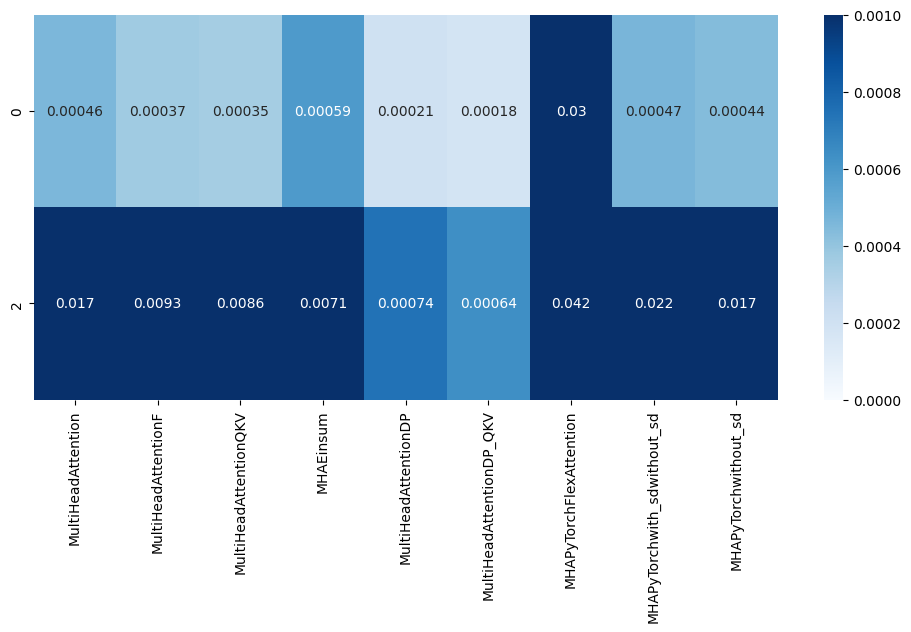

In [185]:
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(data_without_autocast.iloc[[0, 2]] ,annot=True, ax=ax, vmin=0, vmax=0.001, cmap='Blues')

<Axes: >

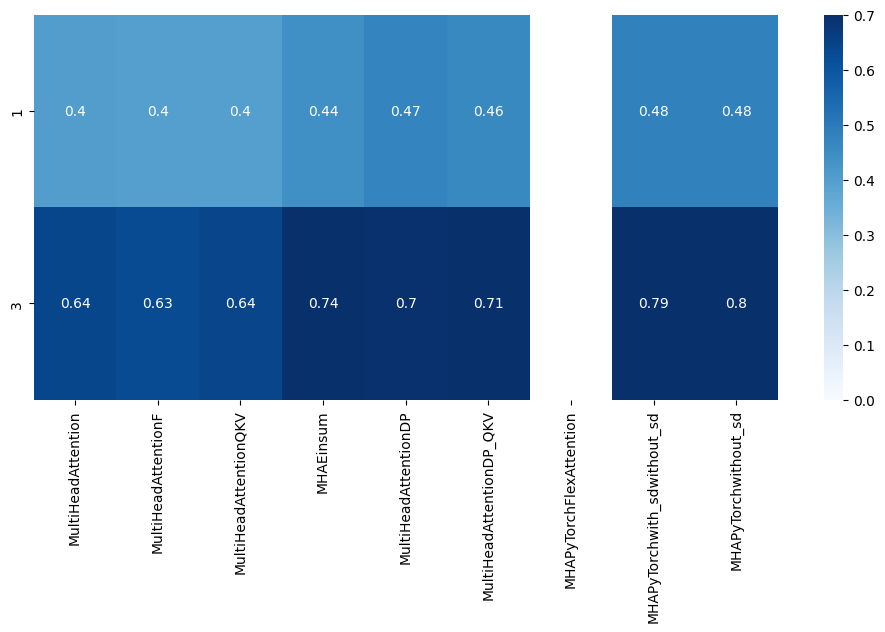

In [186]:
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(data_without_autocast.iloc[[1, 3]] ,annot=True, ax=ax, vmin=0, vmax=0.7, cmap='Blues')

### With autocast

In [187]:
def forward_autocast(model, x_input, device_str):
    with torch.autocast(device_type=device_str, dtype=torch.bfloat16):
        _ = model(x_input)
    
def forward_and_backward_autocast(model, x_input, device_str):
    if x_input.grad is not None:
        x_input.grad.zero_()
    with torch.autocast(device_type=device_str, dtype=torch.bfloat16):
        output = model(x_input)
        loss = output.sum()
        loss.backward()

In [188]:
params = {"d_in":embed_dim, "d_out":embed_dim, "context_length":context_len, "dropout":dropout, "num_heads":num_heads, "qkv_bias":qkv_bias}
flag = False
n = 10

res_autocast = {}
for attention in MHAs:
    name = str(attention).split('.')[-1].replace('\'','').replace('>','')
    if ((attention == MHAPyTorch) and (flag==False)):
        params['need_weights'] = False
        flag = True
        name += "with_sd"
    if ((attention == MHAPyTorch) and (flag)):
        params['need_weights'] = True
        name += "without_sd"
    
    # forward
    ## GPU
    object_MHA = attention(**params)
    object_MHA.to(device)
    execution_time_gpu_forward = timeit.timeit(lambda: forward_autocast(object_MHA, embeddings.to(device), 'cuda'), number=n) / n
    ## CPU
    try:
        object_MHA.to('cpu')
        execution_time_cpu_forward = timeit.timeit(lambda: forward_autocast(object_MHA, embeddings.to('cpu'), 'cpu'), number=n) / n
    except RuntimeError as e:
        print(e)
        execution_time_cpu_forward = np.nan

    # forward + backward
    ## GPU
    object_MHA.to(device)
    execution_time_gpu_forward_backward = timeit.timeit(lambda: forward_and_backward_autocast(object_MHA, embeddings.to(device), 'cuda'), number=n) / n

    ## CPU
    try:
        object_MHA.to('cpu')
        execution_time_cpu_forward_backward = timeit.timeit(lambda: forward_and_backward_autocast(object_MHA, embeddings.to('cpu'), 'cpu'), number=n) / n
    except RuntimeError as e:
        print(e)
        execution_time_cpu_forward_backward = np.nan
    
    res_autocast[name] = [execution_time_gpu_forward, execution_time_cpu_forward, execution_time_gpu_forward_backward, execution_time_cpu_forward_backward]

Expect q/k/v and block_mask to be on the same device but got cpu and cuda:0.
Expect q/k/v and block_mask to be on the same device but got cpu and cuda:0.


In [189]:
data_wit_autocast = pd.DataFrame(res_autocast)

data_without_autocast.index = ['Forward GPU', 'Forward CPU', 'Forward + Backward GPU', 'Forward + Backward CPU']

In [190]:
data_wit_autocast

,MultiHeadAttention,MultiHeadAttentionF,MultiHeadAttentionQKV,MHAEinsum,MultiHeadAttentionDP,MultiHeadAttentionDP_QKV,MHAPyTorchFlexAttention,MHAPyTorchwith_sdwithout_sd,MHAPyTorchwithout_sd
0,0.000545,0.000606,0.000524,0.000813,0.000336,0.000262,0.032106,0.000595,0.000644
1,0.431672,0.439276,0.429125,0.435379,0.431338,0.424234,NaN,0.462898,0.464589
2,0.001493,0.001508,0.001308,0.001685,0.000902,0.000771,0.034256,0.001557,0.001474
3,0.548298,0.546804,0.546657,0.557329,0.604867,0.598229,NaN,0.599683,0.596432


<Axes: >

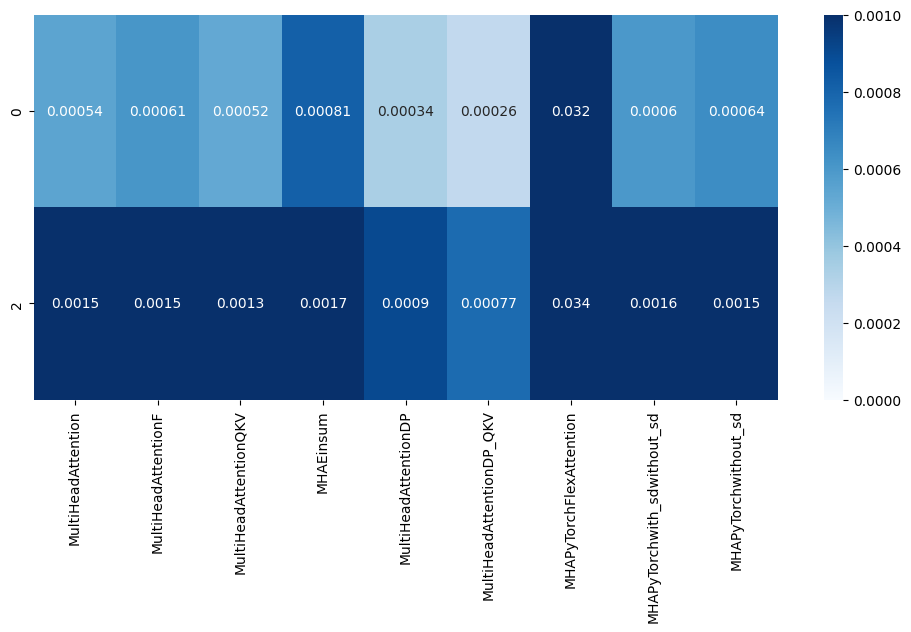

In [191]:
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(data_wit_autocast.iloc[[0, 2]] ,annot=True, ax=ax, vmin=0, vmax=0.001, cmap='Blues')

<Axes: >

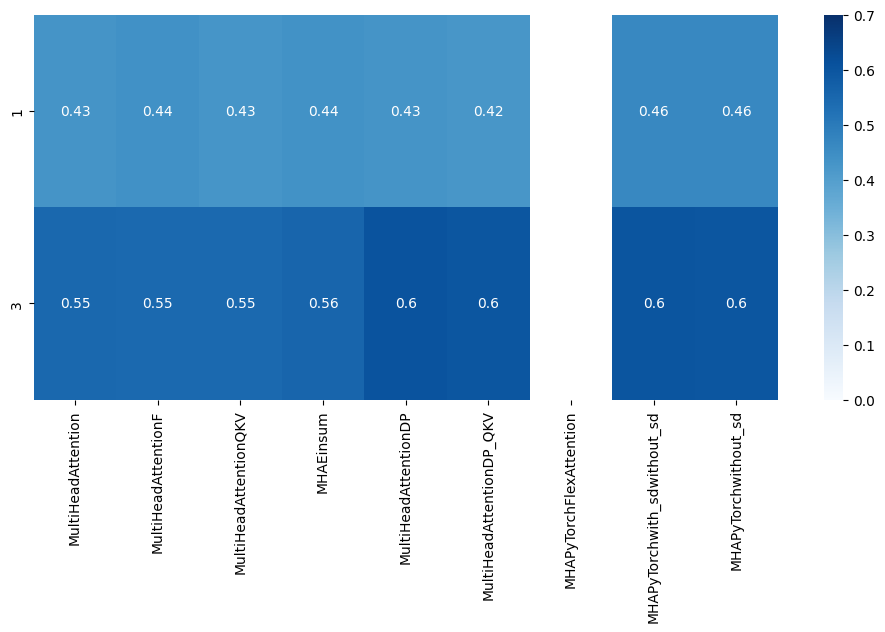

In [192]:
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(data_wit_autocast.iloc[[1, 3]] ,annot=True, ax=ax, vmin=0, vmax=0.7, cmap='Blues')

## Other Attention (from Karpathy)

In [ ]:
class CausalSelfAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads,):
        super().__init__()
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(d_in, 3 * d_in)
        # output projection
        self.c_proj = nn.Linear(d_in, d_in)
        # regularization
        self.n_head = num_heads
        self.n_embd = d_out

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # flash attention
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y